In [10]:
import pandas as pd

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

import torch.optim as optim

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

from torchmetrics import Accuracy

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import numpy as np

from tqdm import tqdm

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import string
import re

plt.style.use('dark_background')

## Upload data

In [2]:
df = pd.read_csv('/kaggle/input/phishing-email-dataset/phishing_email.csv')

In [3]:
df.head()

,text_combined,label
0,hpl nom may 25 2001 see attached file hplno 52...,0
1,nom actual vols 24 th forwarded sabrae zajac h...,0
2,enron actuals march 30 april 1 201 estimated a...,0
3,hpl nom may 30 2001 see attached file hplno 53...,0
4,hpl nom june 1 2001 see attached file hplno 60...,0


## Visualization data

<Axes: xlabel='label', ylabel='count'>

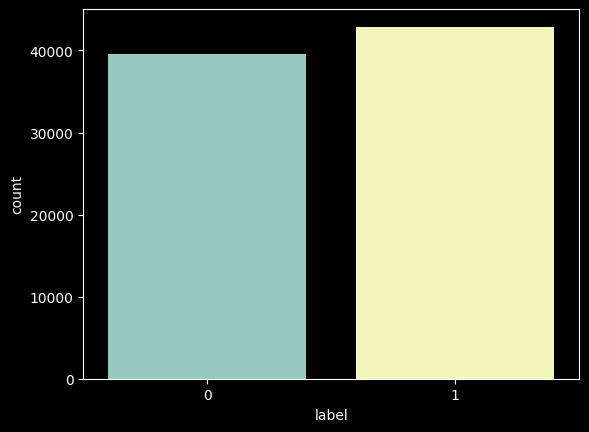

In [4]:
sns.countplot(df, x='label')

In [5]:
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [29]:
text_wordcloud = " ".join(df['text_combined'].values)

### Wordcloud

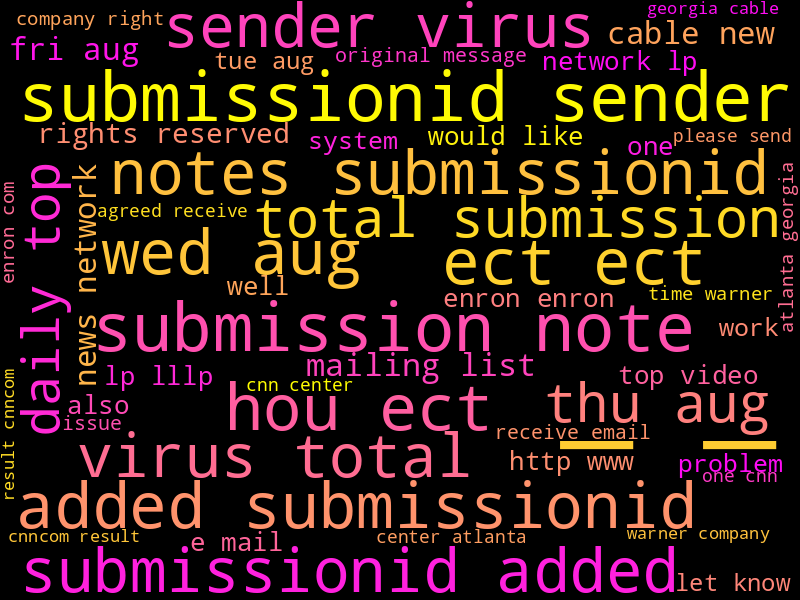

In [31]:
wordcloud = WordCloud(width=800, height=600, stopwords=stop_words, colormap='spring', min_font_size=14, max_words=100).generate(text_wordcloud)
wordcloud.to_image()

### Wordcloud for two classes

In [35]:
not_phishing = []
phishing = []
for text, label in df.values:
    if label == 0:
        not_phishing.append(text)
    else:
        phishing.append(text)

In [39]:
not_phishing_string = " ".join(not_phishing)
phishing = " ".join(phishing)

In [45]:
wordcloud_notspam = WordCloud(width=600, height=400, stopwords=stop_words, colormap="spring", 
                              min_font_size=14).generate(not_phishing_string)
wordcloud_phishing = WordCloud(width=600, height=400, stopwords=stop_words, colormap="spring", 
                           min_font_size=14).generate(phishing_string)

<PIL.Image.Image image mode=RGB size=600x400 at 0x7CDF3AC8E3B0>
<PIL.Image.Image image mode=RGB size=600x400 at 0x7CDF3AC8C820>


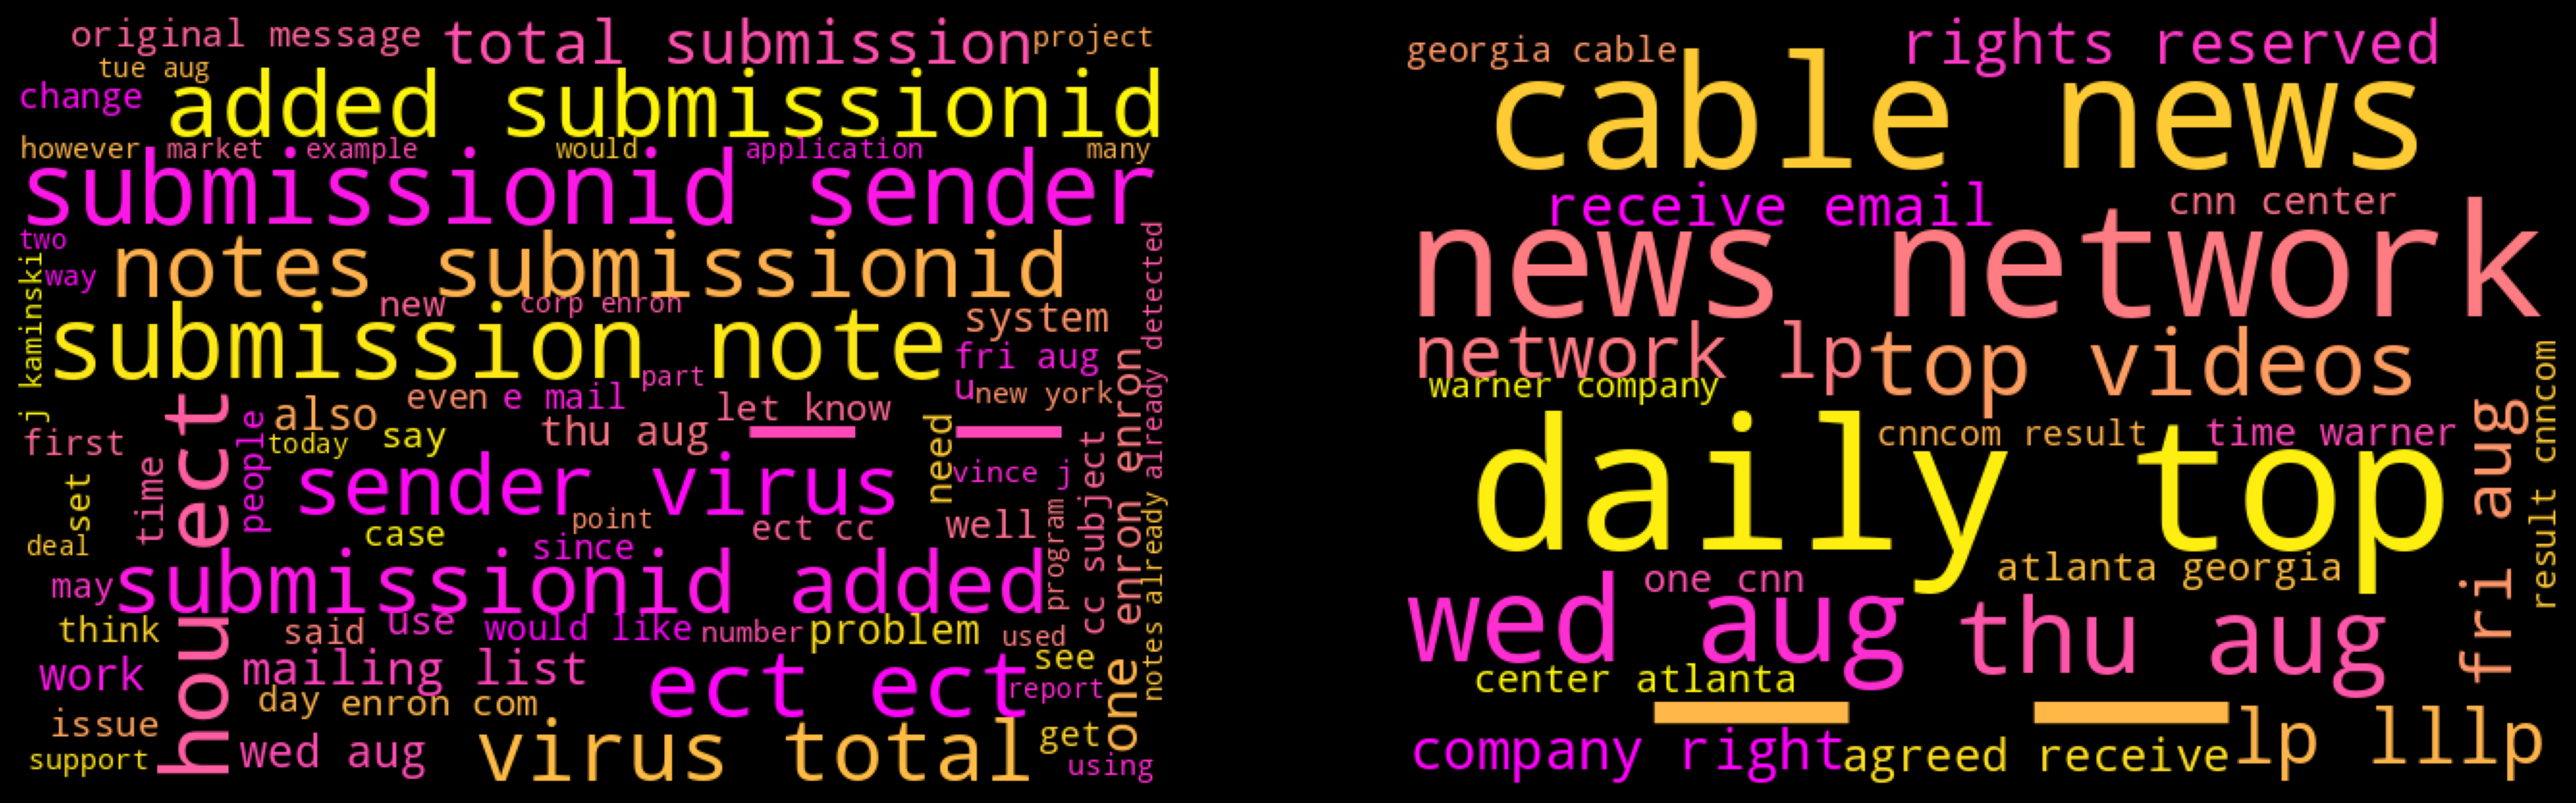

In [53]:
fig, axes = plt.subplots(1, 2, figsize=(20, 20), dpi=200)

axes[0].imshow(wordcloud_notspam)
axes[1].imshow(wordcloud_spam)

axes[0].axis('off')
axes[1].axis('off')

plt.show()

## Cleaned data

In [6]:
 def cleaned_data(text):
        text = text.lower()
        text = re.sub(r'\d+', '', text) # remove numbers
        text = text.translate(str.maketrans('', '', string.punctuation)) # remove punctuation
        text = re.sub(r'\W', ' ', text)
        return text

In [7]:
df['text_combined'] = df['text_combined'].apply(cleaned_data)

## Tokenization

In [8]:
tokenizer = get_tokenizer('basic_english')

def get_yield_tokenizer(batch):
    for txt, _ in batch:
        token = [tk for tk in tokenizer(txt) if tk not in stop_words]
        
        yield token

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
c = 0
for s in get_yield_tokenizer(df.values):
    print(s)
    c += 1
    if c == 5:
        break

['hpl', 'nom', 'may', 'see', 'attached', 'file', 'hplno', 'xls', 'hplno', 'xls']
['nom', 'actual', 'vols', 'th', 'forwarded', 'sabrae', 'zajac', 'hou', 'ect', 'pm', 'enron', 'capital', 'trade', 'resources', 'corp', 'eileen', 'ponton', 'davilal', 'txu', 'com', 'cstonel', 'txu', 'com', 'mjones', 'txu', 'com', 'hpl', 'scheduling', 'enron', 'com', 'liz', 'bellamy', 'enron', 'com', 'szajac', 'enron', 'com', 'cc', 'subject', 'nom', 'actual', 'vols', 'th', 'agree', 'nomination', 'forwarded', 'eileen', 'ponton', 'houston', 'pefs', 'pec', 'charlie', 'stone', 'eileen', 'ponton', 'melissa', 'jones', 'com', 'hpl', 'scheduling', 'enron', 'com', 'liz', 'bellamy', 'enron', 'com', 'szajac', 'enron', 'com', 'subject', 'nom', 'actual', 'vols', 'th', 'pm', 'agree', 'nominated', 'volume', 'records', 'reflect', 'following', 'nom', 'schedule', 'rate', 'eff', 'hrs', 'hour', 'beginning', 'hrs', 'rate', 'eff', 'hrs', 'hour', 'beginning', 'hrs', 'rate', 'eff', 'hrs', 'hour', 'beginning', 'hrs', 'total', 'nomina

In [10]:
vocab = build_vocab_from_iterator(get_yield_tokenizer(df.values), specials=['<unk>'])

In [11]:
vocab.set_default_index(vocab['<unk>'])

In [12]:
vocab.get_itos()[:20]

['<unk>',
 'enron',
 'aug',
 'email',
 'please',
 'new',
 'one',
 'ect',
 'submissionid',
 'would',
 'time',
 'company',
 'information',
 'us',
 'get',
 'top',
 'may',
 'com',
 'message',
 'list']

In [13]:
text_pipeline = lambda x: vocab(tokenizer(x))

## Created DataLoader

In [14]:
train, validation = train_test_split(df.values, random_state=42, test_size=.2)

In [15]:
val, test = train_test_split(validation, random_state=42, test_size=.5)

In [16]:
BATCH = 20

In [17]:
def collate_batch(batch):
    features, targets = zip(*batch)
    
    texts = []
    
    # Pad the features to make them of the same length within the batch
    for txt in features:
        text = text_pipeline(txt)
        texts += [text]
    
    max_len = 50
    
    padded_features = []
    for text in texts:
        if len(text) > 50:
            text = text[:50]
        else:
            text += (max_len - len(text)) * [0]
        padded_features.append(torch.tensor(text))

    # Stack the padded features and targets into tensors
    return torch.stack(padded_features), torch.tensor(targets, dtype=torch.float32).reshape(BATCH, 1)

In [18]:
train_loader = DataLoader(train, batch_size=BATCH, collate_fn=collate_batch, shuffle=True, drop_last=True)
val_loader = DataLoader(val, batch_size=BATCH, collate_fn=collate_batch, drop_last=True)
test_loader = DataLoader(test, batch_size=BATCH, collate_fn=collate_batch, drop_last=True)

In [19]:
for x, y in train_loader:
    print(x.shape)
    break

torch.Size([20, 50])


## Architecture RNN

In [20]:
emb_dim = 50
hidden_dim = 50
n_layers = 1
vocab_size = len(vocab)

In [21]:
class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, n_layers=1):
        super().__init__()
        self.embedding_layer = nn.Embedding(vocab_size, emb_dim)
        self.lstm = nn.LSTM(emb_dim, hidden_dim, batch_first=True, num_layers=n_layers)
#         self.rnn = nn.RNN(emb_dim, hidden_dim, batch_first=True, num_layers=n_layers)
        self.linear = nn.Linear(hidden_dim, 1)
        self.act = nn.Sigmoid()
    
    def forward(self, x):
        x = self.embedding_layer(x)

        h0 = torch.randn(n_layers, len(x), hidden_dim).to(DEVICE)
        c0 = torch.randn(n_layers, len(x), hidden_dim).to(DEVICE)
        
        x, hidden = self.lstm(x, (h0, c0))
        x = self.linear(x)
        x = self.act(x)
        
        return x[:, -1]

## Train

In [22]:
learning_rate = 0.001
step_size = 10
epochs = 10
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [23]:
rnn = RNNClassifier(vocab_size, emb_dim, hidden_dim, n_layers)
rnn = rnn.to(DEVICE)

optimizer = optim.Adam(rnn.parameters(), lr=learning_rate)
loss_function = nn.BCELoss()
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
accuracy = Accuracy(task='binary').to(DEVICE)

In [24]:
losses_train = []
train_loss = []
acc_train = []
total_acc_train = []

losses_val = []
val_loss = []
acc_val = []
total_acc_val = []

In [25]:
# Train
for epoch in range(epochs):
    
    print(f"Epoch {epoch + 1}")

    for iteration, (X_batch, y_batch) in (pbar := tqdm(enumerate(train_loader), 
                                                  total=len(train_loader))):
        X_batch = X_batch.to(DEVICE)
        y_batch = y_batch.to(DEVICE)
        
        rnn.train()
        
        optimizer.zero_grad()
        
        out = rnn(X_batch)
        loss = loss_function(out, y_batch)       
       
        losses_train.append(loss.detach().cpu().numpy().item())
        acc = accuracy(out, y_batch)
        acc_train.append(acc.item())
        
        loss.backward()
        optimizer.step()
    
        pbar.set_description(f'Train: loss: {loss:.5f}\taccuracy: {acc.item():.3f}')

        
    scheduler.step(loss)
    train_loss.append(np.mean(losses_train))
    total_acc_train.append(np.mean(acc_train))
    print(f"Train Error: \n Accuracy: {total_acc_train[-1]} Avg loss: {train_loss[-1]}")
    
# Validation
    for iteration, (X_batch, y_batch) in (pbar := tqdm(enumerate(val_loader),                                                 
                                                  colour='#ff0000', 
                                                  total=len(val_loader))):
        X_batch = X_batch.to(DEVICE)
        y_batch = y_batch.to(DEVICE)
        
        rnn.eval()
        with torch.no_grad():
            pred = rnn(X_batch)
            losses = loss_function(pred, y_batch)
            
            losses_val.append(losses.detach().cpu().numpy().item())
            acc = accuracy(pred, y_batch)
            acc_val.append(acc.item())
    
    val_loss.append(np.mean(losses_val))
    total_acc_val.append(np.mean(acc_val))
    print(f'Validation Error: \n Accuracy: {total_acc_val[-1]} Avg Loss: {val_loss[-1]}')      

Epoch 1


Train: loss: 0.11233	accuracy: 0.950: 100%|██████████| 3299/3299 [00:41<00:00, 80.20it/s]


Train Error: 
 Accuracy: 0.8878902659231188 Avg loss: 0.27026401723137394


100%|██████████| 412/412 [00:02<00:00, 193.80it/s]


Validation Error: 
 Accuracy: 0.9640776632190908 Avg Loss: 0.112523129499219
Epoch 2


Train: loss: 0.02880	accuracy: 1.000: 100%|██████████| 3299/3299 [00:39<00:00, 82.63it/s]


Train Error: 
 Accuracy: 0.93219156878108 Avg loss: 0.17187715397366282


100%|██████████| 412/412 [00:02<00:00, 191.97it/s]


Validation Error: 
 Accuracy: 0.9692961104141856 Avg Loss: 0.09759080853116545
Epoch 3


Train: loss: 0.00231	accuracy: 1.000: 100%|██████████| 3299/3299 [00:39<00:00, 82.95it/s]


Train Error: 
 Accuracy: 0.9512630052382 Avg loss: 0.1263759264248983


100%|██████████| 412/412 [00:02<00:00, 192.97it/s]


Validation Error: 
 Accuracy: 0.9716019359896484 Avg Loss: 0.09857546290044422
Epoch 4


Train: loss: 0.00383	accuracy: 1.000: 100%|██████████| 3299/3299 [00:39<00:00, 82.57it/s]


Train Error: 
 Accuracy: 0.9619430098597951 Avg loss: 0.10016309911173829


100%|██████████| 412/412 [00:02<00:00, 194.34it/s]


Validation Error: 
 Accuracy: 0.9739987810042877 Avg Loss: 0.0900886469391074
Epoch 5


Train: loss: 0.00495	accuracy: 1.000: 100%|██████████| 3299/3299 [00:39<00:00, 83.15it/s]


Train Error: 
 Accuracy: 0.9688572267576867 Avg loss: 0.0827869237416665


100%|██████████| 412/412 [00:02<00:00, 191.28it/s]


Validation Error: 
 Accuracy: 0.9755582473231751 Avg Loss: 0.08595130385938937
Epoch 6


Train: loss: 0.00052	accuracy: 1.000: 100%|██████████| 3299/3299 [00:39<00:00, 83.31it/s]


Train Error: 
 Accuracy: 0.9737470927528267 Avg loss: 0.07019128384181475


100%|██████████| 412/412 [00:02<00:00, 194.72it/s]


Validation Error: 
 Accuracy: 0.9768810630760918 Avg Loss: 0.08274754256260099
Epoch 7


Train: loss: 0.00040	accuracy: 1.000: 100%|██████████| 3299/3299 [00:39<00:00, 83.10it/s]


Train Error: 
 Accuracy: 0.9773372863234444 Avg loss: 0.06087767645445912


100%|██████████| 412/412 [00:02<00:00, 186.43it/s]


Validation Error: 
 Accuracy: 0.9780513129394692 Avg Loss: 0.08115490011417006
Epoch 8


Train: loss: 0.03122	accuracy: 1.000: 100%|██████████| 3299/3299 [00:39<00:00, 82.74it/s]


Train Error: 
 Accuracy: 0.9800753998359827 Avg loss: 0.053685543970267945


100%|██████████| 412/412 [00:02<00:00, 159.05it/s]


Validation Error: 
 Accuracy: 0.9777912574015486 Avg Loss: 0.08333907495768507
Epoch 9


Train: loss: 0.00027	accuracy: 1.000: 100%|██████████| 3299/3299 [00:40<00:00, 81.49it/s]


Train Error: 
 Accuracy: 0.9822067276914598 Avg loss: 0.04801423219388364


100%|██████████| 412/412 [00:02<00:00, 182.52it/s]


Validation Error: 
 Accuracy: 0.9783710848937914 Avg Loss: 0.0824818991189831
Epoch 10


Train: loss: 0.00012	accuracy: 1.000: 100%|██████████| 3299/3299 [00:40<00:00, 82.08it/s]


Train Error: 
 Accuracy: 0.9839405865877388 Avg loss: 0.043343821886830294


100%|██████████| 412/412 [00:02<00:00, 189.23it/s]

Validation Error: 
 Accuracy: 0.9789320342893739 Avg Loss: 0.08313090946159048


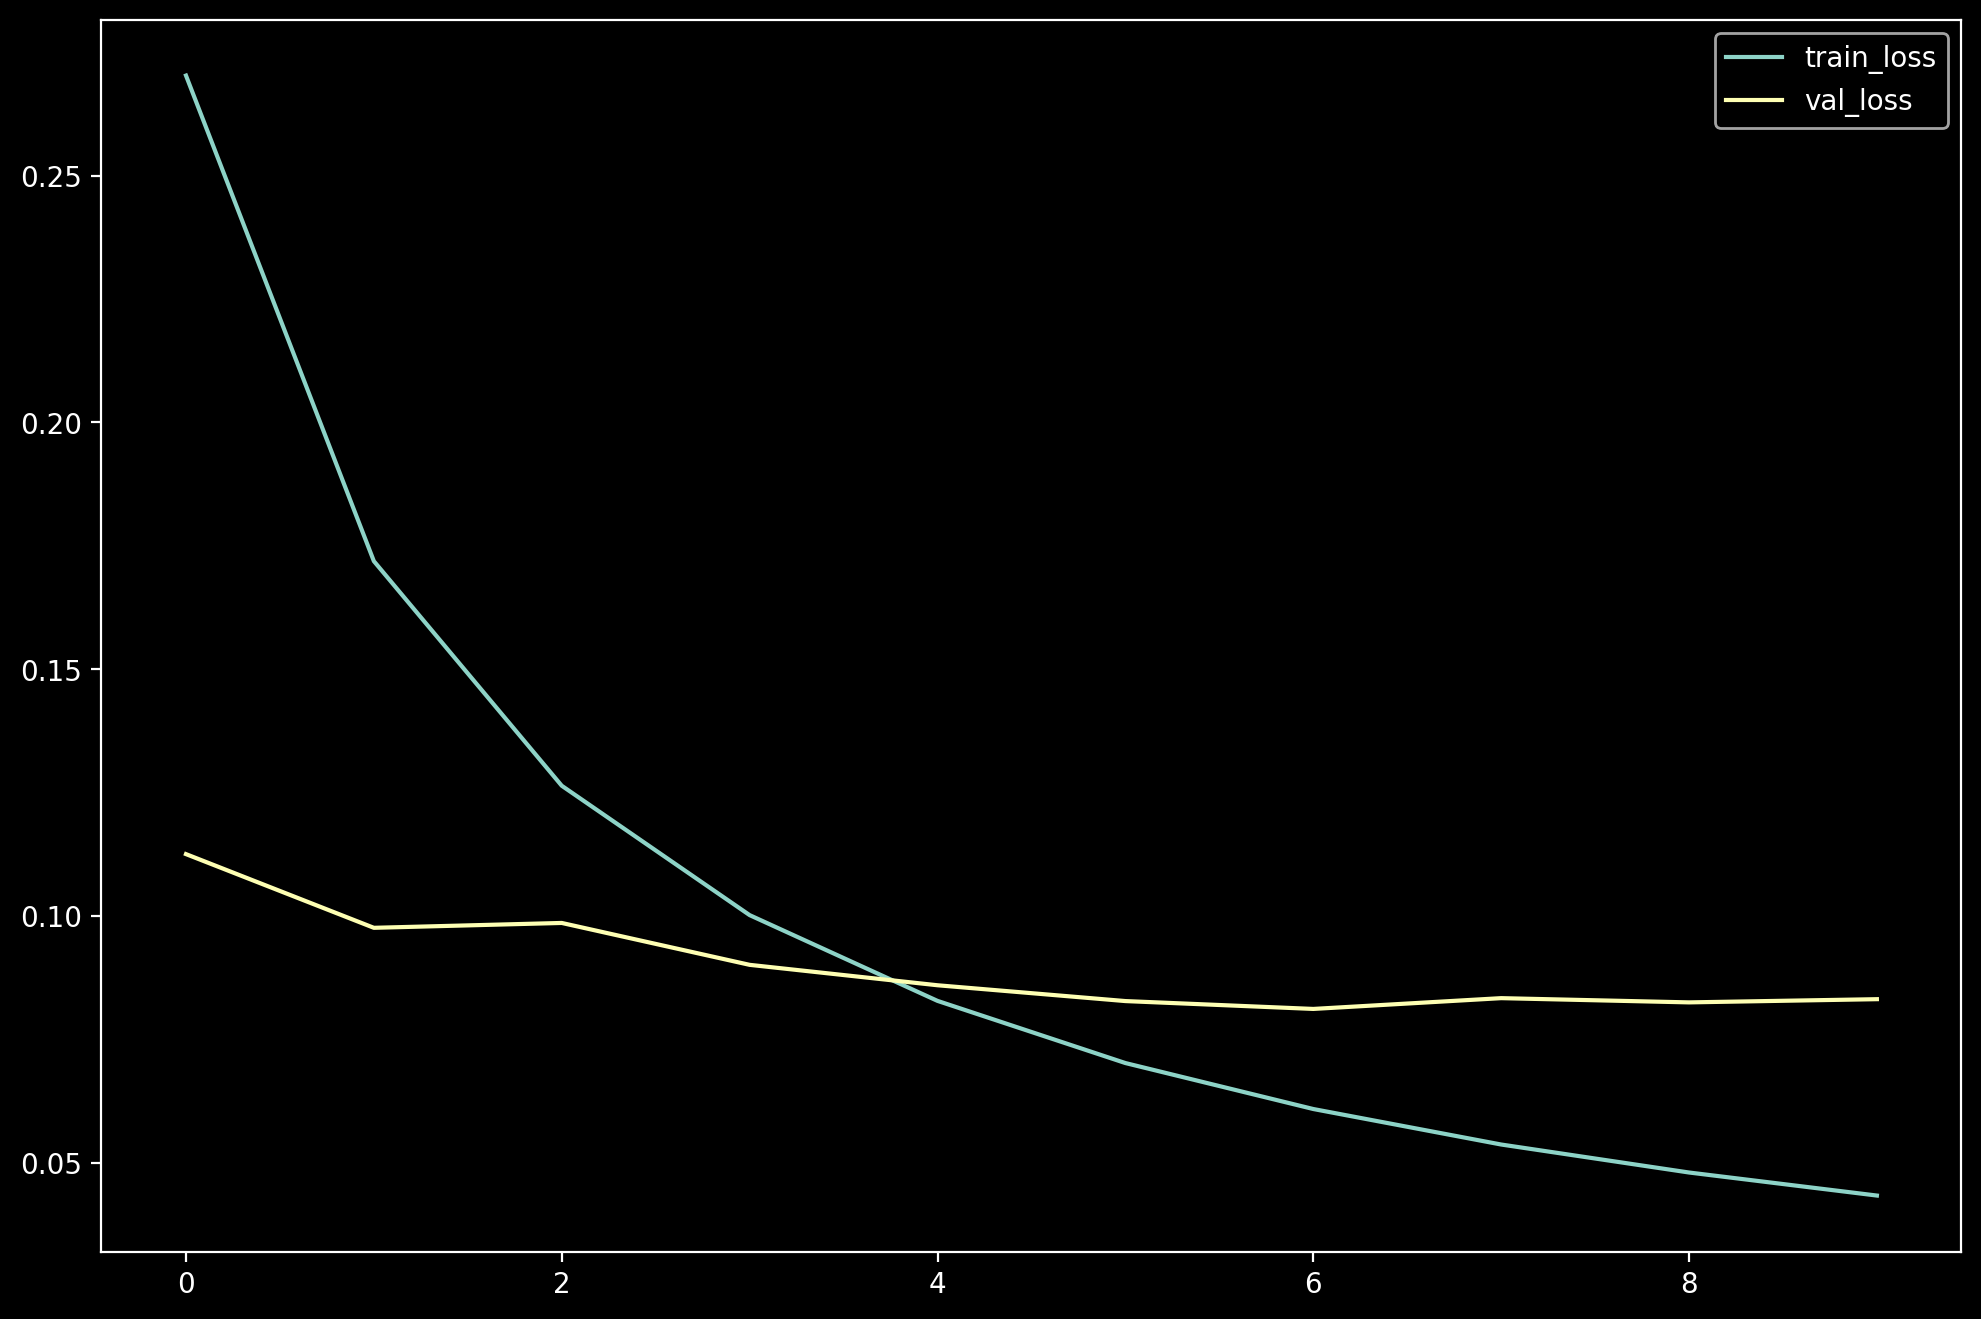

In [26]:
plt.figure(figsize=(12, 8), dpi=200)
plt.plot(range(epochs), train_loss, label='train_loss')
plt.plot(range(epochs), val_loss, label='val_loss')
plt.legend()
plt.show()

## Test

In [27]:
accs = []

for iteration, (X_batch, y_batch) in (pbar := tqdm(enumerate(test_loader),                                                 
                                                  colour='#ff0000', 
                                                  total=len(test_loader))):
    rnn.eval()
    X_batch = X_batch.to(DEVICE)
    y_batch = y_batch.to(DEVICE)
    
    with torch.no_grad():
        out = rnn(X_batch)
        
        acc = accuracy(out, y_batch)
        
    accs.append(acc.detach().cpu().numpy().item())

100%|██████████| 412/412 [00:02<00:00, 201.37it/s]


In [28]:
np.mean(accs)

0.9794902866615832